# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Baseline Models

Today we work on the simplest models to act as a starting point that we will beat.

In [1]:
# imports

import os
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter

In [2]:
# More imports for our traditional machine learning

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

## NLP imports

In the next cell, we have more imports for our NLP related machine learning.  
If the gensim import gives you an error like "Cannot import name 'triu' from 'scipy.linalg' then please run in another cell:  
`!pip install "scipy<1.13"`  
As described on StackOverflow [here](https://stackoverflow.com/questions/78279136/importerror-cannot-import-name-triu-from-scipy-linalg-when-importing-gens).  
Many thanks to students Arnaldo G and Ard V for sorting this.
dz_ !pip -q uninstall -y gensim
!pip -q install --upgrade numpy
!pip -q install gensim

In [8]:
!pip -q uninstall -y gensim
!pip -q install --upgrade numpy
!pip -q install gensim

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.13.1 requires numpy<2.3,>=1.22.4, but you have numpy 2.3.3 which is incompatible.


In [3]:
# NLP related imports

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [4]:
# Finally, more imports for more advanced machine learning

from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

In [5]:
# Constants - used for printing to stdout in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [7]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')
os.environ['HF_WRITE_TOKEN'] = os.getenv('HF_WRITE_TOKEN', 'your-key-if-not-using-env')

In [8]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [9]:
# One more import after logging in

from items import Item

In [10]:
%matplotlib inline

# Loading the pkl files

Let's avoid curating all our data again! Load in the pickle files

If you didn't already create these in Day 2, you can also download them from my google drive (you'll also find the slides here):  
https://drive.google.com/drive/folders/1JwNorpRHdnf_pU0GE5yYtfKlyrKC3CoV?usp=sharing

But note that the files are quite large - you might need to get a coffee!

In [11]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [14]:
# Remind ourselves the training prompt

print(train[0].prompt)


How much does this cost to the nearest dollar?

Delphi FG0166 Fuel Pump Module
Delphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7

Price is $227.00


In [16]:
# Remind a test prompt

print(train[0].price)
#print(test[0].test_prompt)

226.95


## Unveiling a mighty script that we will use a lot!

A rather pleasing Test Harness that will evaluate any model against 250 items from the Test set

And show us the results in a visually satisfying way.

You write a function of this form:

```
def my_prediction_function(item):
    # my code here
    return my_estimate
```

And then you call:

`Tester.test(my_prediction_function)`

To evaluate your model.

In [18]:
class Tester:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()

# Now for something basic

What's the very simplest model you could imagine?

Let's start with a random number generator!

In [19]:
def random_pricer(item):
    return random.randrange(1,1000)

1: Guess: $655.00 Truth: $374.41 Error: $280.59 SLE: 0.31 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $115.00 Truth: $225.00 Error: $110.00 SLE: 0.44 Item: SAMSUNG SyncMaster 906BW 19-Inch LCD Mon...
3: Guess: $26.00 Truth: $62.50 Error: $36.50 SLE: 0.73 Item: FridayParts Water Pump MM433424 MM409303...
4: Guess: $760.00 Truth: $599.99 Error: $160.01 SLE: 0.06 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $282.00 Truth: $16.99 Error: $265.01 SLE: 7.59 Item: MasterPieces Trendz - Freakshakes 300pc ...
6: Guess: $251.00 Truth: $31.98 Error: $219.02 SLE: 4.14 Item: Red Hound Auto 2 Stainless Door Trailer ...
7: Guess: $229.00 Truth: $101.78 Error: $127.22 SLE: 0.65 Item: Walker Quiet-Flow SS 21745 Direct Fit Ex...
8: Guess: $143.00 Truth: $289.00 Error: $146.00 SLE: 0.49 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $755.00 Truth: $635.86 Error: $119.14 SLE: 0.03 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $105.00 Truth: $66.09 

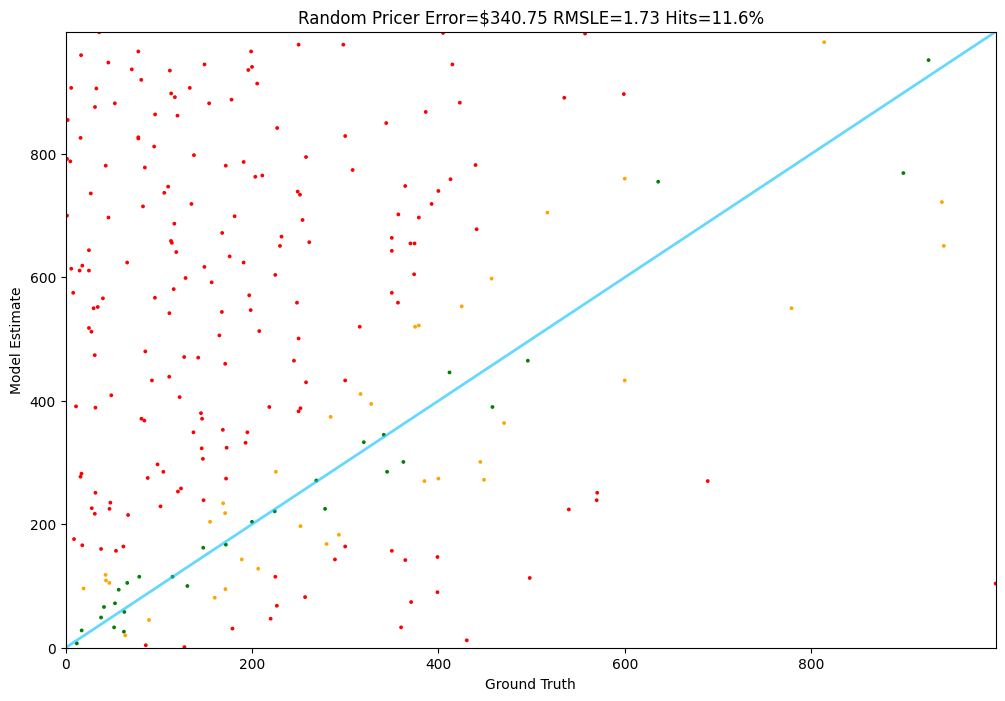

In [20]:
# Set the random seed

random.seed(42)

# Run our TestRunner
Tester.test(random_pricer)

In [21]:
# That was fun!
# We can do better - here's another rather trivial model

training_prices = [item.price for item in train]
training_average = sum(training_prices) / len(training_prices)

def constant_pricer(item):
    return training_average

1: Guess: $220.46 Truth: $374.41 Error: $153.95 SLE: 0.28 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $220.46 Truth: $225.00 Error: $4.54 SLE: 0.00 Item: SAMSUNG SyncMaster 906BW 19-Inch LCD Mon...
3: Guess: $220.46 Truth: $62.50 Error: $157.96 SLE: 1.56 Item: FridayParts Water Pump MM433424 MM409303...
4: Guess: $220.46 Truth: $599.99 Error: $379.53 SLE: 1.00 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $220.46 Truth: $16.99 Error: $203.47 SLE: 6.30 Item: MasterPieces Trendz - Freakshakes 300pc ...
6: Guess: $220.46 Truth: $31.98 Error: $188.48 SLE: 3.63 Item: Red Hound Auto 2 Stainless Door Trailer ...
7: Guess: $220.46 Truth: $101.78 Error: $118.68 SLE: 0.59 Item: Walker Quiet-Flow SS 21745 Direct Fit Ex...
8: Guess: $220.46 Truth: $289.00 Error: $68.54 SLE: 0.07 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $220.46 Truth: $635.86 Error: $415.40 SLE: 1.12 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $220.46 Truth: $66.09 E

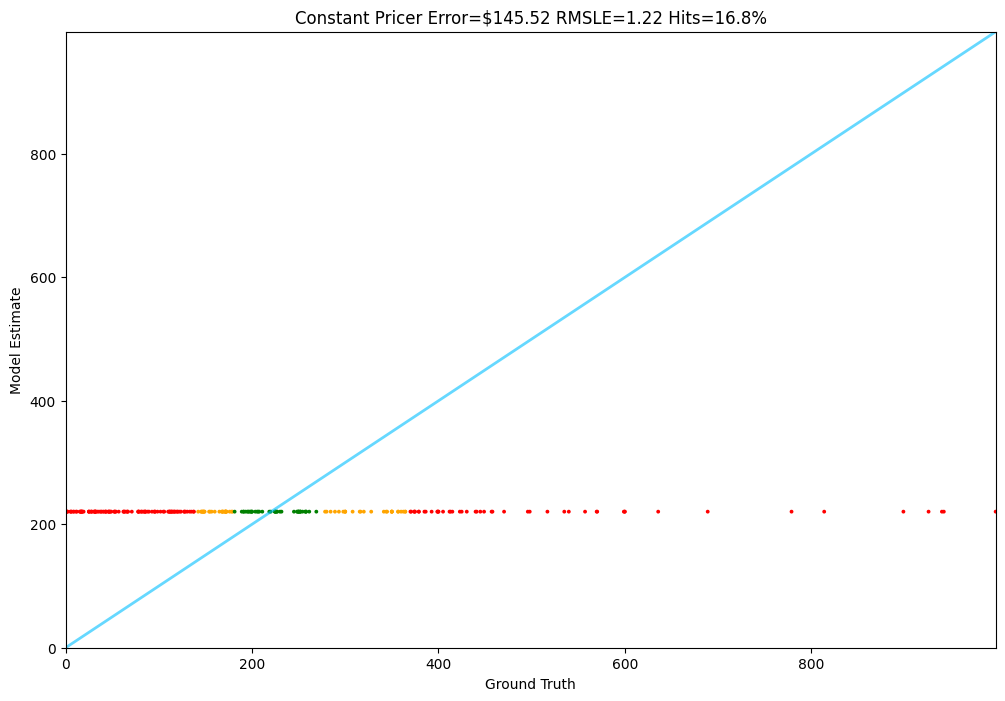

In [22]:
# Run our constant predictor
Tester.test(constant_pricer)


In [23]:
train[0].details

'{"Brand": "Delphi", "Fit Type": "Vehicle Specific Fit", "Item Dimensions LxWxH": "19.7 x 7.7 x 5.1 inches", "Item Weight": "2.2 Pounds", "Auto Part Position": "Unknown", "Operation Mode": "Mechanical", "Manufacturer": "Delphi", "Model": "FUEL PUMP", "Product Dimensions": "19.7 x 7.7 x 5.1 inches", "Country of Origin": "USA", "Item model number": "FG0166", "Is Discontinued By Manufacturer": "No", "Exterior": "Painted", "Manufacturer Part Number": "FG0166", "OEM Part Number": "25326856, 89060639, A30416, E4061R, MU242", "Best Sellers Rank": {"Automotive": 913571, "Automotive Replacement Electric Fuel Pumps": 6568}, "Domestic Shipping": "Item can be shipped within U.S.", "International Shipping": "This item is not eligible for international shipping.  Learn More", "Date First Available": "August 9, 2006"}'

In [24]:
# Create a new "features" field on items, and populate it with json parsed from the details dict

for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)

# Look at one

In [25]:
train[0].features.keys()

dict_keys(['Brand', 'Fit Type', 'Item Dimensions LxWxH', 'Item Weight', 'Auto Part Position', 'Operation Mode', 'Manufacturer', 'Model', 'Product Dimensions', 'Country of Origin', 'Item model number', 'Is Discontinued By Manufacturer', 'Exterior', 'Manufacturer Part Number', 'OEM Part Number', 'Best Sellers Rank', 'Domestic Shipping', 'International Shipping', 'Date First Available'])

In [26]:
# Look at 20 most common features in training set

feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f]+=1

feature_count.most_common(40)

[('Date First Available', 367063),
 ('Manufacturer', 357144),
 ('Brand', 351225),
 ('Item Weight', 349686),
 ('Best Sellers Rank', 332383),
 ('Item model number', 270839),
 ('Product Dimensions', 256004),
 ('Manufacturer Part Number', 188244),
 ('Color', 171907),
 ('Is Discontinued By Manufacturer', 163444),
 ('Material', 131128),
 ('Country of Origin', 124481),
 ('Model', 84929),
 ('OEM Part Number', 75410),
 ('Package Dimensions', 75205),
 ('Item Dimensions LxWxH', 73053),
 ('Style', 70575),
 ('Special Feature', 67643),
 ('Exterior', 66076),
 ('Vehicle Service Type', 64539),
 ('Part Number', 62186),
 ('Batteries Required?', 60370),
 ('Included Components', 57595),
 ('Special Features', 56109),
 ('Size', 50405),
 ('Item Package Quantity', 48945),
 ('Batteries Included?', 46403),
 ('Voltage', 42207),
 ('Power Source', 41931),
 ('Finish Type', 41048),
 ('Position', 36401),
 ('Auto Part Position', 35967),
 ('Mounting Type', 34928),
 ('Model Name', 33501),
 ('Shape', 29997),
 ('', 28803),

In [27]:
# Now some janky code to pluck out the Item Weight
# Don't worry too much about this: spoiler alert, it's not going to be much use in training!

def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [28]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]

4.75 Tons


In [29]:
average_weight = sum(weights)/len(weights)
average_weight

14.064972848873149

In [30]:
def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight

In [31]:
def get_rank(item):
    rank_dict = item.features.get("Best Sellers Rank")
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks)
    return None

In [32]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks)/len(ranks)
average_rank

439368.7676655353

In [33]:
def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank

In [34]:
def get_text_length(item):
    return len(item.test_prompt())

In [35]:
# investigate the brands

brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand]+=1

# Look at most common 40 brands

brands.most_common(40)

[('HP', 5160),
 ('Power Stop', 3949),
 ('Dorman', 3481),
 ('Detroit Axle', 3473),
 ('Dell', 3073),
 ('ACDelco', 2401),
 ('Lenovo', 2315),
 ('Evan Fischer', 1894),
 ('BUYAUTOPARTS!', 1800),
 ('SAMSUNG', 1569),
 ('ASUS', 1340),
 ('Callahan BRAKE PARTS', 1304),
 ('Rareelectrical', 1257),
 ('CURT', 1255),
 ('Garage-Pro', 1188),
 ('Sony', 1161),
 ('Coverking', 1152),
 ('Spectra Premium', 1137),
 ('Cardone', 1120),
 ('R1 Concepts', 1103),
 ('A-Premium', 1103),
 ('Canon', 1097),
 ('Auto Dynasty', 1088),
 ('WeatherTech', 1074),
 ('TYC', 1011),
 ('Kohler', 1003),
 ('EBC Brakes', 996),
 ('GM', 981),
 ('K&N', 944),
 ('ECCPP', 943),
 ('APS', 937),
 ('Walker', 931),
 ('DB Electrical', 886),
 ('SCITOO', 868),
 ('AKKON', 836),
 ('Covercraft', 799),
 ('SPEC-D TUNING', 782),
 ('Generic', 762),
 ('DNA MOTORING', 761),
 ('AM Autoparts', 754)]

In [36]:
TOP_ELECTRONICS_BRANDS = ["hp", "dell", "lenovo", "samsung", "asus", "sony", "canon", "apple", "intel"]
def is_top_electronics_brand(item):
    brand = item.features.get("Brand")
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS

In [37]:
def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "rank": get_rank_with_default(item),
        "text_length": get_text_length(item),
        "is_top_electronics_brand": 1 if is_top_electronics_brand(item) else 0
    }

In [38]:
# Look at features in a training item
get_features(train[0])

{'weight': 2.2,
 'rank': 460069.5,
 'text_length': 748,
 'is_top_electronics_brand': 0}

In [39]:
# A utility function to convert our features into a pandas dataframe

def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

4.75 Tons


In [40]:
# Traditional Linear Regression!

np.random.seed(42)

# Separate features and target
feature_columns = ['weight', 'rank', 'text_length', 'is_top_electronics_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

# Train a Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# Predict the test set and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

weight: 0.2654770232695749
rank: 1.6834185715792237e-05
text_length: 0.005770519082759197
is_top_electronics_brand: 209.65041484787608
Intercept: 195.961232895647
Mean Squared Error: 34203.03946177236
R-squared Score: 0.05876113368395275


In [41]:
# Function to predict price for a new item

def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

1: Guess: $217.24 Truth: $374.41 Error: $157.17 SLE: 0.29 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $419.41 Truth: $225.00 Error: $194.41 SLE: 0.39 Item: SAMSUNG SyncMaster 906BW 19-Inch LCD Mon...
3: Guess: $207.39 Truth: $62.50 Error: $144.89 SLE: 1.41 Item: FridayParts Water Pump MM433424 MM409303...
4: Guess: $412.27 Truth: $599.99 Error: $187.72 SLE: 0.14 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $201.69 Truth: $16.99 Error: $184.70 SLE: 5.87 Item: MasterPieces Trendz - Freakshakes 300pc ...
6: Guess: $229.52 Truth: $31.98 Error: $197.54 SLE: 3.78 Item: Red Hound Auto 2 Stainless Door Trailer ...
7: Guess: $206.23 Truth: $101.78 Error: $104.45 SLE: 0.49 Item: Walker Quiet-Flow SS 21745 Direct Fit Ex...
8: Guess: $202.70 Truth: $289.00 Error: $86.30 SLE: 0.12 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $221.03 Truth: $635.86 Error: $414.83 SLE: 1.11 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $228.40 Truth: $66.09

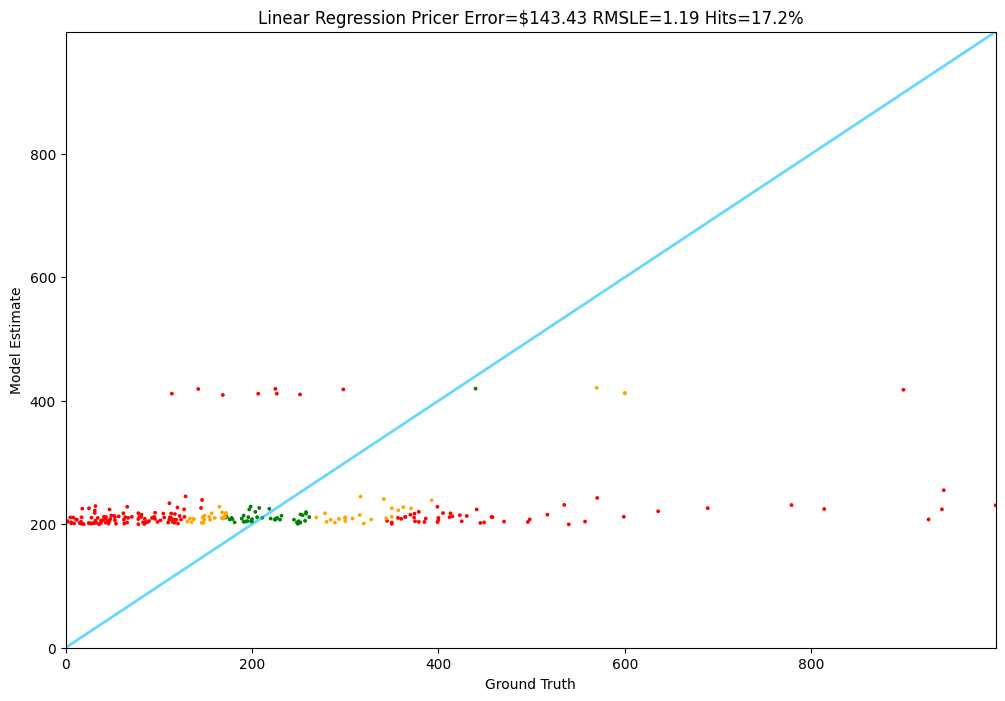

In [42]:
# test it

Tester.test(linear_regression_pricer)

In [43]:
# For the next few models, we prepare our documents and prices
# Note that we use the test prompt for the documents, otherwise we'll reveal the answer!!

prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [44]:
# Use the CountVectorizer for a Bag of Words model

np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [45]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

1: Guess: $281.38 Truth: $374.41 Error: $93.03 SLE: 0.08 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $189.78 Truth: $225.00 Error: $35.22 SLE: 0.03 Item: SAMSUNG SyncMaster 906BW 19-Inch LCD Mon...
3: Guess: $212.41 Truth: $62.50 Error: $149.91 SLE: 1.47 Item: FridayParts Water Pump MM433424 MM409303...
4: Guess: $347.80 Truth: $599.99 Error: $252.19 SLE: 0.30 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $113.12 Truth: $16.99 Error: $96.13 SLE: 3.41 Item: MasterPieces Trendz - Freakshakes 300pc ...
6: Guess: $243.68 Truth: $31.98 Error: $211.70 SLE: 4.02 Item: Red Hound Auto 2 Stainless Door Trailer ...
7: Guess: $256.84 Truth: $101.78 Error: $155.06 SLE: 0.85 Item: Walker Quiet-Flow SS 21745 Direct Fit Ex...
8: Guess: $263.56 Truth: $289.00 Error: $25.44 SLE: 0.01 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $428.87 Truth: $635.86 Error: $206.99 SLE: 0.15 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $190.94 Truth: $66.09 Er

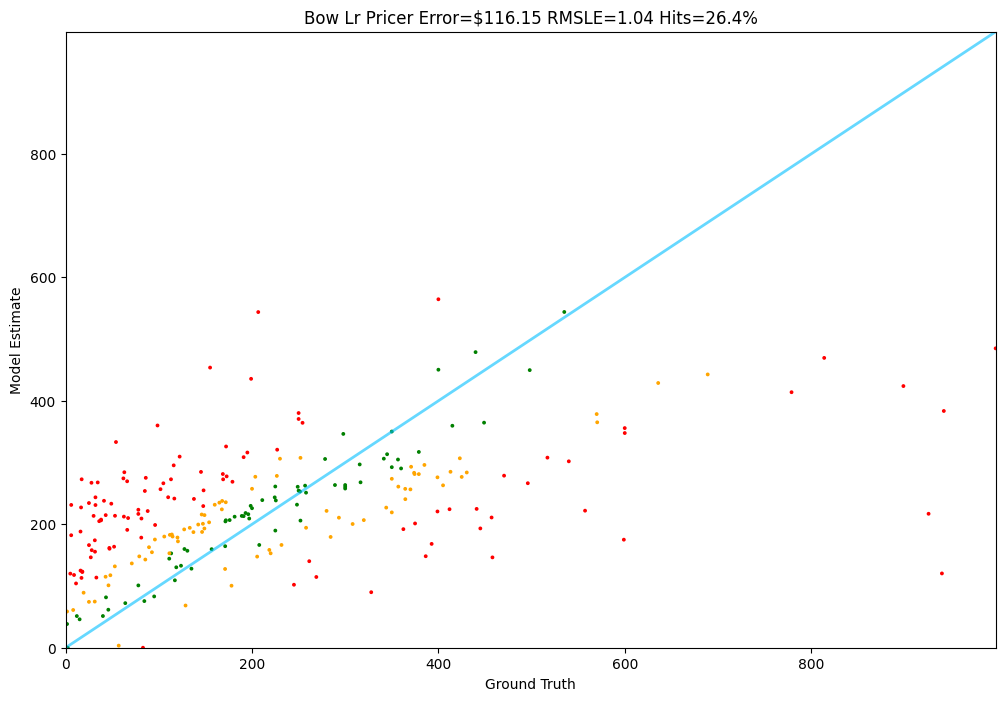

In [46]:
# test it

Tester.test(bow_lr_pricer)

In [47]:
# The amazing word2vec model, implemented in gensim NLP library

np.random.seed(42)

# Preprocess the documents
processed_docs = [simple_preprocess(doc) for doc in documents]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

In [48]:
# This step of averaging vectors across the document is a weakness in our approach

def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

In [49]:
# Run Linear Regression on word2vec

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [50]:
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

1: Guess: $250.51 Truth: $374.41 Error: $123.90 SLE: 0.16 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $191.15 Truth: $225.00 Error: $33.85 SLE: 0.03 Item: SAMSUNG SyncMaster 906BW 19-Inch LCD Mon...
3: Guess: $177.33 Truth: $62.50 Error: $114.83 SLE: 1.07 Item: FridayParts Water Pump MM433424 MM409303...
4: Guess: $374.80 Truth: $599.99 Error: $225.19 SLE: 0.22 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $32.82 Truth: $16.99 Error: $15.83 SLE: 0.40 Item: MasterPieces Trendz - Freakshakes 300pc ...
6: Guess: $258.73 Truth: $31.98 Error: $226.75 SLE: 4.26 Item: Red Hound Auto 2 Stainless Door Trailer ...
7: Guess: $333.18 Truth: $101.78 Error: $231.40 SLE: 1.39 Item: Walker Quiet-Flow SS 21745 Direct Fit Ex...
8: Guess: $269.08 Truth: $289.00 Error: $19.92 SLE: 0.01 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $426.14 Truth: $635.86 Error: $209.72 SLE: 0.16 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $211.00 Truth: $66.09 Er

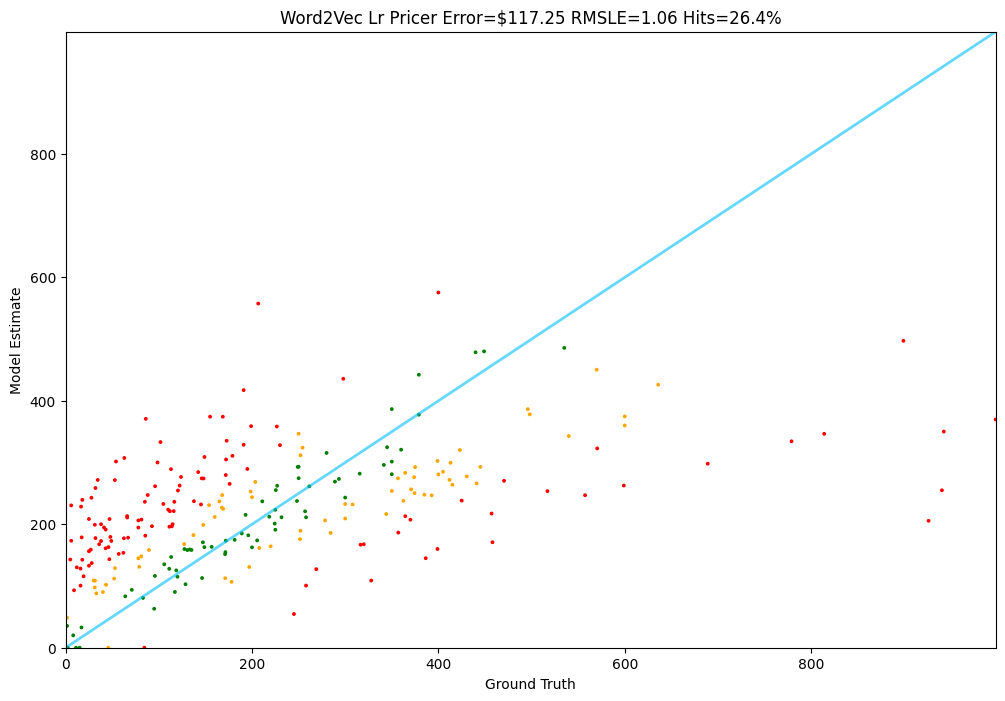

In [51]:
Tester.test(word2vec_lr_pricer)

In [52]:
# Support Vector Machines

np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v, prices)

,epsilon,0.0
,tol,0.0001
,C,1.0
,loss,'epsilon_insensitive'
,fit_intercept,True
,intercept_scaling,1.0
,dual,'auto'
,verbose,0
,random_state,None
,max_iter,1000


In [53]:
def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

1: Guess: $241.33 Truth: $374.41 Error: $133.08 SLE: 0.19 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $163.48 Truth: $225.00 Error: $61.52 SLE: 0.10 Item: SAMSUNG SyncMaster 906BW 19-Inch LCD Mon...
3: Guess: $126.72 Truth: $62.50 Error: $64.22 SLE: 0.49 Item: FridayParts Water Pump MM433424 MM409303...
4: Guess: $316.14 Truth: $599.99 Error: $283.85 SLE: 0.41 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $0.00 Truth: $16.99 Error: $16.99 SLE: 8.35 Item: MasterPieces Trendz - Freakshakes 300pc ...
6: Guess: $218.66 Truth: $31.98 Error: $186.68 SLE: 3.60 Item: Red Hound Auto 2 Stainless Door Trailer ...
7: Guess: $280.01 Truth: $101.78 Error: $178.23 SLE: 1.01 Item: Walker Quiet-Flow SS 21745 Direct Fit Ex...
8: Guess: $193.71 Truth: $289.00 Error: $95.29 SLE: 0.16 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $382.35 Truth: $635.86 Error: $253.51 SLE: 0.26 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $175.66 Truth: $66.09 Erro

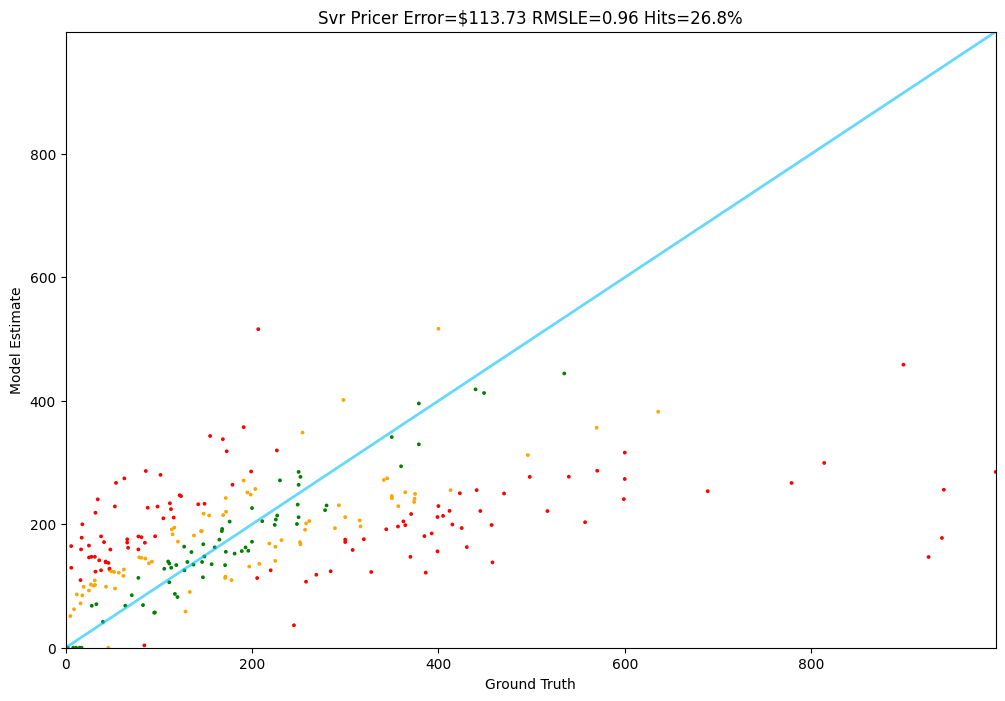

In [54]:
Tester.test(svr_pricer)

In [55]:
# And the powerful Random Forest regression

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(X_w2v, prices)

KeyboardInterrupt: 

In [ ]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

In [ ]:
Tester.test(random_forest_pricer)